<h1 id="Blood-cells-image-classification-with-CNN-model" style="font-size: 25.998px; margin-top: 0.538em; margin-bottom: 0px; font-family: 'helvetica neue' , 'helvetica' , 'arial' , sans-serif; font-weight: bold; line-height: 1; color: #000000;"><strong>Blood cells image classification with CNN model</strong></h1>
<p>Image classification with CNN. precursor for a transfer learning project. The CNN model will be replaced by a assembled model on top of a pre-trained model.</p>
<p>data source <a href="https://www.kaggle.com/paultimothymooney/blood-cells" target="_blank" rel="noopener">https://www.kaggle.com/paultimothymooney/blood-cells</a></p>
<p>multi-class single label image classification</p>
<p>load data with flow_from_directory</p>
<p>augmentation ready</p>
<p>&nbsp;</p>
<p>v0 resize to <strong>60, 80</strong></p>
<p>v1 redize to <strong>120, 160&nbsp; &nbsp;71%</strong></p>
<p>&nbsp;</p>
<p style="margin-top: 1em; font-size: 14px;">cnn2 v2&nbsp;</p>
<p style="margin-top: 1em; font-size: 14px;">deeper network 120 160&nbsp; &nbsp;74%</p>
<p style="margin-top: 1em; font-size: 14px;">&nbsp;v3</p>
<p style="margin-top: 1em; font-size: 14px;">data augment, flip, shift&nbsp; 84.5%</p>
<p style="margin-top: 1em; font-size: 14px;">ir-0.0002</p>
<p style="margin-top: 1em; font-size: 14px;">---------------------------------</p>
<p style="margin-top: 1em; font-size: 14px;">replace cnn by mobilenetv2</p>
<p style="margin-top: 1em; font-size: 14px;">&nbsp;</p>
<p style="margin-top: 1em; font-size: 14px;">&nbsp;</p>
<p style="margin-top: 1em; font-size: 14px;">&nbsp;</p>

In [1]:
#from __future__ import absolute_import, division, print_function, unicode_literals

# Install TensorFlow
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
print(tf.__version__)

TensorFlow 2.x selected.
2.0.0


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import pydot
import os
import math, time, random, datetime


import tensorflow as tf
print(tf.__version__)

#keras = tf.keras
from tensorflow.keras import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import SGD, Adam

from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.callbacks import LearningRateScheduler, TensorBoard

#import tensorflow_datasets as tfds

2.0.0


In [3]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [4]:
tf.test.gpu_device_name()
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 9285631421135001988, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 8720456136617224742
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 8160181181771427305
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11330115994
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 10725794538801615021
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

In [0]:
#from google.colab import drive

#drive.mount('/content/gdrive')

In [8]:
!ls

blood-cells.zip  sample_data


In [10]:
from google.colab import files
uploadedFile = files.upload()

Saving blood-cells.zip to blood-cells.zip


In [0]:
!unzip blood-cells.zip

<h2 id="Exploring-and-processing data">Exploring and processing&nbsp;data</h2>


In [0]:
#gdrive="/content/gdrive/My Drive/Colab Notebooks/transfer learning/data/blood_cells/dataset2-master/images/"

gdrive="/content/dataset2-master/dataset2-master/images/"


In [15]:
batch_size = 32
image_height = 120
image_width = 160

datagen = ImageDataGenerator(
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    rescale=1./255
        )

datagen_test = ImageDataGenerator(
        rescale=1./255
        )

train_gen = datagen.flow_from_directory(gdrive + 'TRAIN/', 
                                          target_size=(image_height,image_width), 
                                          batch_size=batch_size, 
                                          class_mode='categorical',
                                          shuffle=True)
val_gen = datagen_test.flow_from_directory(gdrive + 'TEST/', 
                                       target_size=(image_height,image_width), 
                                       batch_size=batch_size, 
                                       class_mode='categorical',
                                       shuffle=False)
test_gen = datagen_test.flow_from_directory(gdrive + 'TEST_SIMPLE/', 
                                       target_size=(image_height,image_width), 
                                       batch_size=71, 
                                       class_mode=None,
                                       shuffle=False)



Found 9957 images belonging to 4 classes.
Found 2487 images belonging to 4 classes.
Found 71 images belonging to 4 classes.


Val indices:  {'EOSINOPHIL': 0, 'LYMPHOCYTE': 1, 'MONOCYTE': 2, 'NEUTROPHIL': 3}


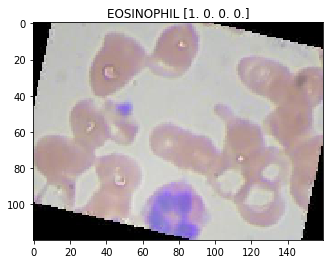

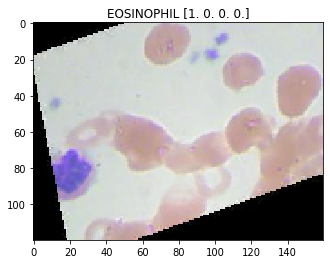

In [16]:
# Only required if featurewise_center or featurewise_std_normalization or zca_whitening are set to True.
# datagen.fit(train_gen)

images, class_vect = val_gen.next()

class_dict = val_gen.class_indices
label_dict = {c:l for l,c in class_dict.items()}

print("Val indices: ", class_dict)

nclasses = len(label_dict)

for i in range(0,2):
    image = images[i]
    plt.imshow(image)
    plt.title(label_dict[np.argmax(class_vect[i])]+' '+str(class_vect[i]))
    plt.show()

## Pre-trained model + classification head


In [31]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu', input_shape=(image_height,image_width, 3)),
    tf.keras.layers.MaxPooling2D(pool_size = 2, strides = 2),
    tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu'),
    tf.keras.layers.MaxPooling2D(pool_size = 2, strides = 2),
    tf.keras.layers.Conv2D(filters = 128, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu'),
    tf.keras.layers.MaxPooling2D(pool_size = 2, strides = 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(units=nclasses, activation='softmax')
])


learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=learning_rate),
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 120, 160, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 60, 80, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 60, 80, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 30, 40, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 30, 40, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 15, 20, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 38400)            

In [0]:
IMG_SHAPE = (image_height,image_width, 3) # default 299x299x3

base_model = MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

X = GlobalAveragePooling2D()(base_model.output)
#X = Flatten()(base_model.output)

X = Dense(64, activation='relu')(X)

X = Dropout(rate=0.5)(X)

OUTPUT = Dense(nclasses, activation='softmax')(X)

model = Model(inputs=base_model.input, outputs=OUTPUT)


num_base_layer = len(base_model.layers)

print("Number of layers in the base model: ", num_base_layer)


In [0]:
fine_tune_last = 0 # conv2d_1

base_model.trainable = True

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:num_base_layer-fine_tune_last]:
    layer.trainable =  False

## set weight
#layer.set_weights(weights)
#keras.initializers.glorot_normal(seed=None)

model.compile(optimizer=Adam(),
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

#tf.keras.utils.plot_model(model)

<h3>train model</h3>


In [0]:
class LRTensorBoard(TensorBoard):
    def __init__(self, log_dir, **kwargs):  
        super().__init__(log_dir=log_dir, **kwargs)

    def on_epoch_end(self, epoch, logs=None):
        logs.update({'learning_rate': tf.keras.backend.eval(self.model.optimizer.lr)})
        super().on_epoch_end(epoch, logs)

In [0]:
logs_base_dir = ".\logs"
logdir = os.path.join(logs_base_dir, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

os.makedirs(logs_base_dir, exist_ok=True)
tensorboard = TensorBoard(logdir, histogram_freq=1)
tensorboard_lr=LRTensorBoard(logdir)


In [0]:
#%load_ext tensorboard
#%reload_ext tensorboard
#logs_base_dir = ".\logs"

#%tensorboard --logdir {logsdir}  # http://localhost:6006/


In [0]:
ir0=0.0005
annealer = LearningRateScheduler(lambda x: ir0 * 0.95 ** x) 
# 0.95^10=.60, ^20=.36, ^30=.21, ^40=.13


In [33]:
initial_epoch = 0
epochs = 30
steps_per_epoch = train_gen.n//train_gen.batch_size +1
validation_steps = val_gen.n//val_gen.batch_size  +1 # 

print("train: steps_per_epoch = ", steps_per_epoch)
print("val:  validation_steps = ", validation_steps)



train: steps_per_epoch =  312
val:  validation_steps =  78


In [34]:
loss0,accuracy0 = model.evaluate_generator(val_gen, steps = validation_steps, verbose=1)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

78/78 [==============================] - 7s 90ms/step - loss: 1.3872 - accuracy: 0.2602
initial loss: 1.39
initial accuracy: 0.26


In [35]:
s0 = time.time()

history = model.fit_generator(
        train_gen,
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        validation_data=val_gen,
        validation_steps=validation_steps,
        initial_epoch=initial_epoch,
        callbacks=[annealer])


s1 = time.time()
print("training time:", time.strftime('%H:%M:%S', time.gmtime(s1 - s0)))

Epoch 1/30
312/312 [==============================] - 82s 263ms/step - loss: 1.3884 - accuracy: 0.2495 - val_loss: 1.3864 - val_accuracy: 0.2509
Epoch 2/30
312/312 [==============================] - 80s 256ms/step - loss: 1.3867 - accuracy: 0.2460 - val_loss: 1.3862 - val_accuracy: 0.2509
Epoch 3/30
312/312 [==============================] - 80s 255ms/step - loss: 1.3864 - accuracy: 0.2469 - val_loss: 1.3863 - val_accuracy: 0.2396
Epoch 4/30
312/312 [==============================] - 79s 255ms/step - loss: 1.3865 - accuracy: 0.2469 - val_loss: 1.3863 - val_accuracy: 0.2493
Epoch 5/30
312/312 [==============================] - 79s 253ms/step - loss: 1.3857 - accuracy: 0.2506 - val_loss: 1.3861 - val_accuracy: 0.2425
Epoch 6/30
312/312 [==============================] - 79s 254ms/step - loss: 1.3841 - accuracy: 0.2696 - val_loss: 1.3468 - val_accuracy: 0.3357
Epoch 7/30
312/312 [==============================] - 79s 253ms/step - loss: 1.3030 - accuracy: 0.3629 - val_loss: 1.1301 - val_ac

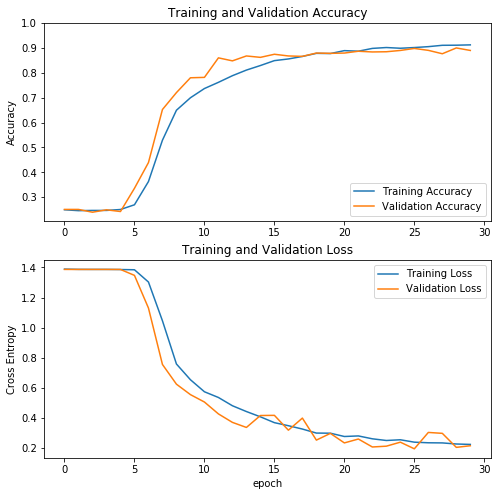

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
#plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [0]:
!mkdir model

gdrive_m="model/"

#model.save(gdrive_m + "blood_cells_mnv2_aug_lr=0-0001d_20ep.h5")

## **Prediction**



In [0]:
test_gen.reset()
test_images = test_gen.next()

filenames = test_gen.filenames
test_labels = [line.split("/")[0] for line in filenames]

In [39]:
test_steps = test_gen.n//test_gen.batch_size
test_gen.reset()
pred = model.predict_generator(test_gen,
                              steps=test_steps,
                              verbose=1)

1/1 [==============================] - 0s 184ms/step


In [0]:
predicted_class_indices=np.argmax(pred,axis=1)
predictions = [label_dict[k] for k in predicted_class_indices]

In [0]:

out = pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})
#out.to_csv("transfer_learning_blood_cells_cnn_test_output_v1.csv",index=False)

In [42]:
out.head()

,Filename,Predictions
0,EOSINOPHIL/_0_5239.jpeg,EOSINOPHIL
1,EOSINOPHIL/_10_5476.jpeg,EOSINOPHIL
2,EOSINOPHIL/_11_9310.jpeg,EOSINOPHIL
3,EOSINOPHIL/_12_2599.jpeg,EOSINOPHIL
4,EOSINOPHIL/_1_5031.jpeg,EOSINOPHIL


In [0]:

correct = ['correct' if t==p else 'incorrect' for t,p in zip(test_labels, predictions)]

In [44]:
c=0
for i in range(test_gen.n):
    c+=int(test_labels[i]==predictions[i])
test_acc=c/test_gen.n
print("test acc=%.3f"%(test_acc))

test acc=0.944


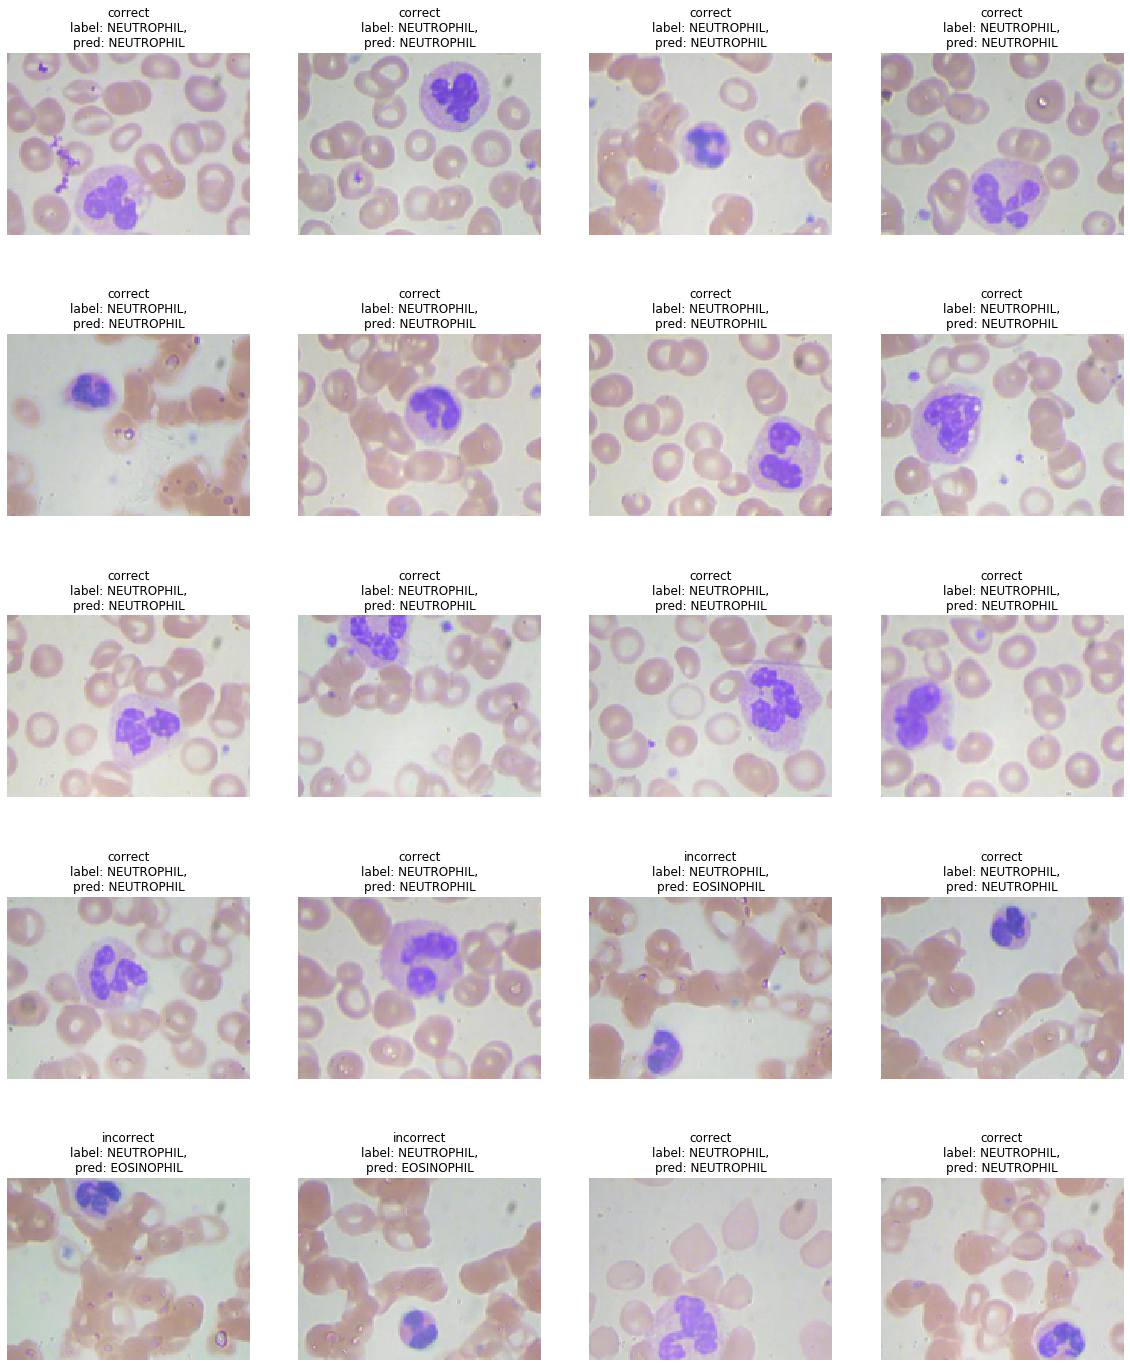

In [45]:
i=30
plt.figure(figsize=(20,25))
for IMGNO in range(i,i+20):  
    plt.subplot(5, 4, IMGNO-i+1)
    plt.imshow(test_images[IMGNO])
    plt.title(correct[IMGNO] +'\nlabel: '+ test_labels[IMGNO]+',\npred: '+predictions[IMGNO])
    plt.axis('off')
#plt.subplots_adjust(wspace=0.3, hspace=-0.1)
plt.show()    




# **References**

data source
https://www.kaggle.com/paultimothymooney/blood-cells

load image using image_generator
https://keras.io/preprocessing/image/

https://machinelearningmastery.com/how-to-load-large-datasets-from-directories-for-deep-learning-with-keras/

guid for transfer learning 
https://www.tensorflow.org/tutorials/images/transfer_learning

good reading
https://towardsdatascience.com/an-intuitive-guide-to-deep-network-architectures-65fdc477db41

https://towardsdatascience.com/a-simple-guide-to-the-versions-of-the-inception-network-7fc52b863202

comparing models
https://keras.io/applications/

output label method https://medium.com/@vijayabhaskar96/tutorial-image-classification-with-keras-flow-from-directory-and-generators-95f75ebe5720



